## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import cv2
import os
import glob
import time
import pickle
import imageio
import numpy as np
imageio.plugins.ffmpeg.download()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# NOTE: the last import is only valid for scikit-learn version >= 0.17
# for scikit-learn <= 0.18 use:
# from sklearn.cross_validation import train_test_split

%matplotlib inline

## Dataset

In [2]:
def get_data():
    basedir = 'dataset/vehicles/'
    image_types = os.listdir(basedir)
    cars = []
    for imtype in image_types:
        cars.extend(glob.glob(basedir+imtype+'/*'))
    
    print('Number of vehicle images found: ', len(cars))
    with open('cars.txt', 'w') as f:
        for fn in cars:
            f.write(fn+'/n')
        
    basedir = 'dataset/non-vehicles/'
    image_types = os.listdir(basedir)
    notcars = []
    for imtype in image_types:
        notcars.extend(glob.glob(basedir+imtype+'/*'))
    
    print('Number of non-vehicle images found: ', len(notcars))
    with open('notcars.txt', 'w') as f:
        for fn in notcars:
            f.write(fn+'/n')
    return cars, notcars

cars, notcars = get_data()

Number of vehicle images found:  8792
Number of non-vehicle images found:  8968


## Features

#### Spatial Binning of Color

In [1]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel() 
    color2 = cv2.resize(img[:,:,1], size).ravel() 
    color3 = cv2.resize(img[:,:,2], size).ravel() 
    return np.hstack((color1, color2, color3))

#### Histograms of Color

In [4]:
def color_hist(img, nbins=32):     # bins_range=(0, 256)
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

#### Histogram of Oriented Gradients

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    else:      
        hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return hog_features

### Extract Features

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

###### Sliding windows

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

##### Draw boxes

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

##### Single Image Features

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def single_img_features(image, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # Create a list to append feature vectors to
    img_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    # Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

## Classifier

#### Define the Classifier

In [10]:
def define_classifier(cars, notcars, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    print('Using:', orient, 'orientations,', pix_per_cell, 'pixels per cell,', cell_per_block, 'cells per block,', hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
    
    t=time.time()
    
    car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)    

    notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)    

    t2 = time.time()
    print(round((t2-t), 2), 'seconds to compute features...')

    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Store in a pickle
    #with open('X_scaler.pickle', 'wb') as f:
        #pickle.dump(X_scaler, f)
        
    #with open('scaled_X.pickle', 'wb') as f:
        #pickle.dump(scaled_X, f)
        
    #with open('y.pickle', 'wb') as f:
        #pickle.dump(y, f)
        
    print(round((time.time()-t2), 2), 'seconds to store features...')
        
    print('Training data storage done')


#### Train the Classifier
##### Shuffle and split the training and test datasets

In [11]:
def train_classifier():
    with open('scaled_X.pickle', 'rb') as f:
        scaled_X = pickle.load(f)
        
    with open('y.pickle', 'rb') as f:
        y = pickle.load(f)
        
    rand_state = np.random.randint(0,100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC
    parameters = {'C':[0.01, 0.001, 0.0001]}
    svr =  LinearSVC()
    svc = GridSearchCV(svr, parameters)

    # Check the training time for the SVC
    t = time.time()

    svc.fit(X_train, y_train)

    t2 = time.time()
    print(round((t2-t), 2), 'seconds to train SVC...')

    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print('Best params:', svc.best_params_)
    
    # Store svc in pickle
    with open('svc.pickle', 'wb') as f:
        pickle.dump(svc, f)
        
    print('SVC stored in pickle')

#### Color conversion

In [12]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#### Detect cars by sliding window through image and checking features

In [13]:
def find_cars(img, scale, ystart, ystop, svc, X_scaler):
    img_boxes = []
    t = time.time()
    count = 0
    draw_img = np.copy(img)
    # Uncomment when img is jpg & training data is png
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))  
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 1 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # This will give you a series of HOG window extracts
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                count += 1
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    #print(time.time()-t, 'seconds to run, total windows = ', count)
    
    return draw_img, img_boxes, count

#### Add heatmap

In [14]:
def add_heat(heatmap, windows):
    for window in windows:
        heatmap[window[0][1]:window[1][1],window[0][0]:window[1][0]] += 1
        #heatmap = 255 * heatmap / np.max(heatmap)
    return heatmap

#### Apply heatmap threshold

In [15]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#### Draw boxes on labelled, heated areas

In [16]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### (Optional) Display text data on image

In [17]:
def show_image(image1, image2, count):
    # Text Display
    text1 = 'Total windows found: ' + str(count)
    org1 = (50,50)

    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.95
    color = (255,255,255)
    thickness = 2
    cv2.putText(image1, text1, org1, font, scale, color, thickness)
    """
    import cv2
    s_img = cv2.imread("smaller_image.png")
    l_img = cv2.imread("larger_image.jpg")
    x_offset=y_offset=50
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
    """
    
    return image1

#### Visualization of results

In [18]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Test on Images

### Image Pipeline

In [19]:
def img_pipeline(img_src, threshold, svc, X_scaler):
    img = mpimg.imread(img_src)
    
    # Using a scale = 1., equivalent to a window size 64x64, within the range of 400 < y < 480
    draw_img1, img_boxes1, count1 = find_cars(img, 1., 400, 480, svc, X_scaler)
    # Using a scale = 1.5, equivalent to a window size 96x96, within the range of 400 < y < 528
    draw_img2, img_boxes2, count2 = find_cars(img, 1.5, 400, 528, svc, X_scaler)
    # Using a scale = 2., equivalent to a window size 128x128, within the range of 400 < y < 656
    draw_img3, img_boxes3, count3 = find_cars(img, 2., 400, 656, svc, X_scaler)
    
    # Consolidate results
    draw_img = cv2.add(draw_img1, draw_img2, draw_img3)
    img_boxes = img_boxes1 + img_boxes2 + img_boxes3
    count = count1 + count2 + count3
    
    # Apply heatmap
    heatmap = np.zeros_like(img[:,:,0])
    heatmap1 = add_heat(heatmap, img_boxes)
    heatmap2 = apply_threshold(heatmap1, threshold)
    
    # Label areas and draw boxes
    labels = label(heatmap2)
    heat = draw_labeled_bboxes(np.copy(heatmap2), labels)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    draw_img = show_image(draw_img, heatmap2, count)
    
    return img, draw_img

#### Test getting HOG features of random car and notcar images

In [22]:
# Choose random car / not-car indices    
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'YCrCb'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)    

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)    

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### Visualize HOG features

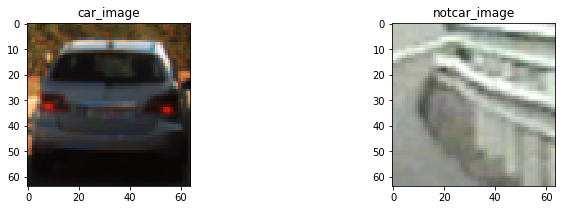

In [23]:
images = [car_image, notcar_image]
titles = ['car_image', 'notcar_image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 2, images, titles)
#fig.savefig('output_images/car_not_car.png', bbox_inches='tight')

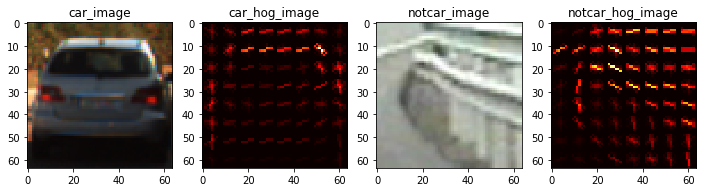

In [24]:
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car_image', 'car_hog_image', 'notcar_image', 'notcar_hog_image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)
#fig.savefig('output_images/HOG_example.png', bbox_inches='tight')

#### Visualize Windows

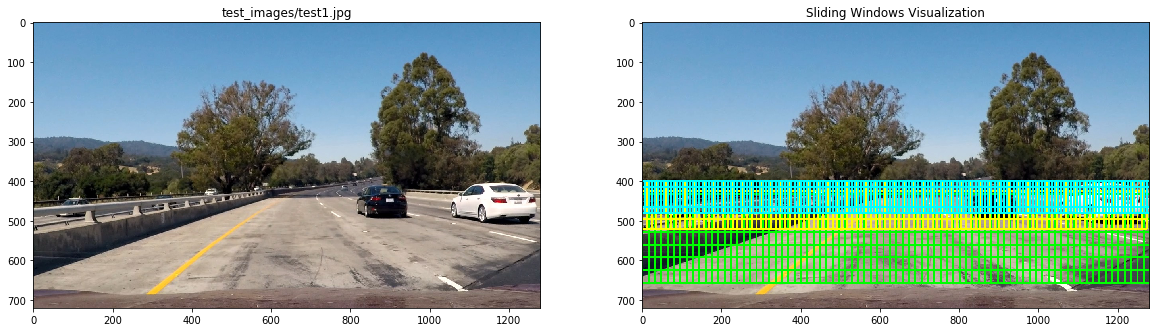

In [25]:
src_img = 'test_images/test1.jpg'
test_img = mpimg.imread(src_img)
title = 'Sliding Windows Visualization'

# Using scale = 2.0, window = 128x128
windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 656], xy_window=(128, 128), xy_overlap=(0.875, 0.75))
draw_img = draw_boxes(test_img, windows, color=(0, 255, 0), thick=4)
    
# Using scale = 1.5, window = 96x96
windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 528], xy_window=(96, 96), xy_overlap=(0.875, 0.75))
draw_img = draw_boxes(draw_img, windows, color=(255, 255, 0), thick=4)
    
# Using scale = 1.0, window = 64x64
windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 480], xy_window=(64, 64), xy_overlap=(0.875, 0.75))
draw_img = draw_boxes(draw_img, windows, color=(0, 255, 255), thick=4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title(src_img, fontsize=12)
ax2.imshow(draw_img)
ax2.set_title(title, fontsize=12)
fig.savefig('output_images/sliding_windows.png', bbox_inches='tight')

#### General Parameters

In [26]:
# Define feature parameters
color_space = 'YCrCb'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

define_classifier(cars, notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

Using: 11 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


140.94 seconds to compute features...
4.62 seconds to store features...
Training data storage done


In [27]:
 train_classifier()

Feature vector length: 9636
111.43 seconds to train SVC...
Test Accuracy of SVC =  0.9932
Best params: {'C': 0.0001}
SVC stored in pickle


In [28]:
with open('svc.pickle', 'rb') as pick:
    svc = pickle.load(pick)
    
with open('X_scaler.pickle', 'rb') as pick:
    X_scaler = pickle.load(pick)

#### Visualize Processed Test Images

In [54]:
example_images = glob.glob('test_images/test*')
out_images = []
out_titles = []
threshold = 3

for img_src in example_images:
    
    source_img, draw_img = img_pipeline(img_src, threshold, svc, X_scaler)
    
    out_images.append(source_img)
    out_images.append(draw_img)
    out_titles.append(img_src)
    out_titles.append('final image')

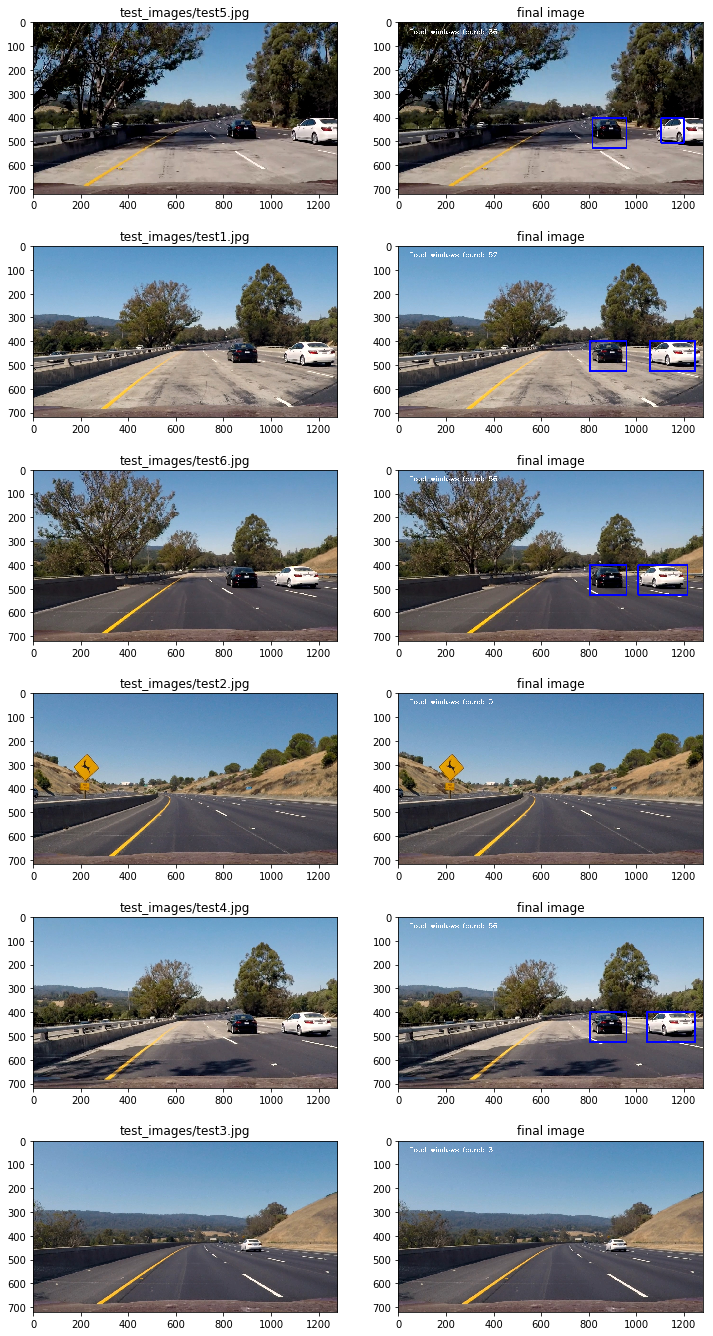

In [55]:
fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, out_images, out_titles)
#fig.savefig('output_images/sliding_window.png', bbox_inches='tight')

## Test on Videos

### Video Pipeline

In [29]:
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
class Heatmaps():
    def _init_(self):
        self.maxlen = 0
        self.heatmaps = []
        
    def average_heat(self, heatmap, maxlen):
        self.maxlen = maxlen
        self.heatmaps.append(heatmap)
        """
        if len(self.heatmaps) == self.maxlen:
            return sum(self.heatmaps)/self.maxlen
        else:
            return sum(self.heatmaps)/len(self.heatmaps)
        """
        return sum(self.heatmaps)


In [47]:
def pipeline(img, svc, X_scaler):
    threshold = 20

    # Using a scale = 1., equivalent to a window size 64x64, within the range of 400 < y < 480
    draw_img1, img_boxes1, count1 = find_cars(img, 1., 400, 480, svc, X_scaler)
    # Using a scale = 1.5, equivalent to a window size 96x96, within the range of 400 < y < 528
    draw_img2, img_boxes2, count2 = find_cars(img, 1.5, 400, 528, svc, X_scaler)
    # Using a scale = 2., equivalent to a window size 128x128, within the range of 400 < y < 656
    draw_img3, img_boxes3, count3 = find_cars(img, 2., 400, 656, svc, X_scaler)
    
    # Consolidate results
    draw_img = cv2.add(draw_img1, draw_img2, draw_img3)
    img_boxes = img_boxes1 + img_boxes2 + img_boxes3
    count = count1 + count2 + count3
    
    # Add heatmap
    heatmap = np.zeros_like(img[:,:,0])
    heatmap1 = add_heat(heatmap, img_boxes)
    heatmap2 = heat.average_heat(heatmap1, maxlen)
    heatmap3 = apply_threshold(heatmap2, threshold)

    # Label areas and place in boxes
    labels = label(heatmap3)
    draw_img4 = draw_labeled_bboxes(np.copy(img), labels)
    heat_lbl = draw_labeled_bboxes(np.copy(heatmap3), labels)
    draw_img4 = show_image(draw_img4, heatmap3, (labels[1]) )

    return draw_img4
    #return heatmap1
    #return heat_lbl

In [48]:
def process_video(image):
    clip = pipeline(image, svc, X_scaler)
    return clip

#### Process video

In [33]:
maxlen = 25     # number of frames to average
heat = Heatmaps()
heat.heatmaps = deque(maxlen = maxlen)

In [51]:
test_video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_video_clip = clip1.fl_image(process_video)
%time test_video_clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:54<00:01,  1.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 54.5 s, sys: 84 ms, total: 54.6 s
Wall time: 55.4 s


In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_output))

In [34]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_video)
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [30:02<00:01,  1.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 30min 4s, sys: 2.63 s, total: 30min 7s
Wall time: 30min 3s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [ ]:
vidcap = cv2.VideoCapture('project_video.mp4')
vidcap.set(cv2.CAP_PROP_POS_MSEC,37000) 
success,image = vidcap.read()
if success:
    cv2.imwrite("output_images/project_video_frames/project_video_frame6.jpg", image)
    cv2.imshow("37.000sec",image)
    cv2.waitKey()            

#### Exploration of Video Images

In [49]:
example_images = glob.glob('output_images/project_video_frames/project_video_frame*')
heat_images = []
heat_titles = []
lbl_images = []
lbl_titles = []

for img_src in example_images:
    
    source_img = mpimg.imread(img_src)
    draw_img = pipeline(img, svc, X_scaler)

    heat_images.append(source_img)
    heat_images.append(heatmap)
    heat_titles.append(img_src)
    heat_titles.append('heatmap')

    lbl_images.append(source_img)
    lbl_images.append(heatlbl)
    lbl_titles.append(img_src)
    lbl_titles.append('labelled heatmap')

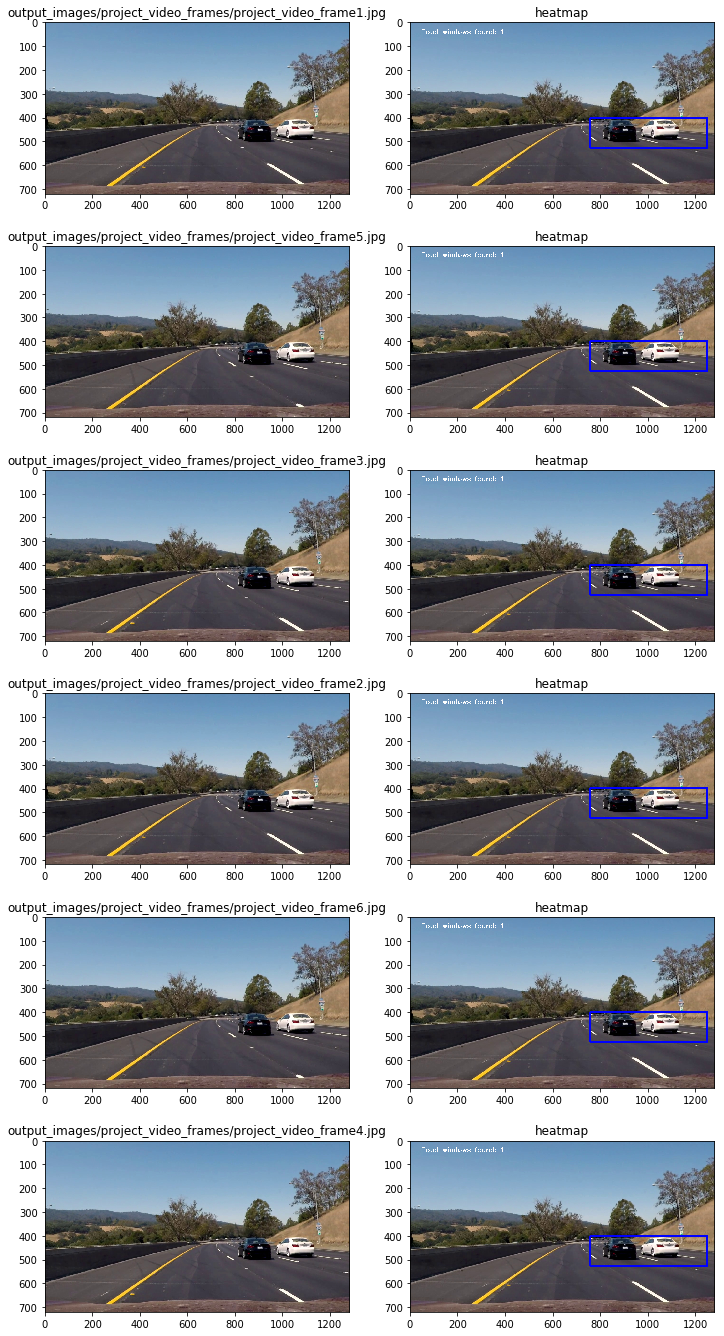

In [40]:
fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, heat_images, heat_titles)
#fig.savefig('output_images/bboxes_and_heat.png', bbox_inches='tight')

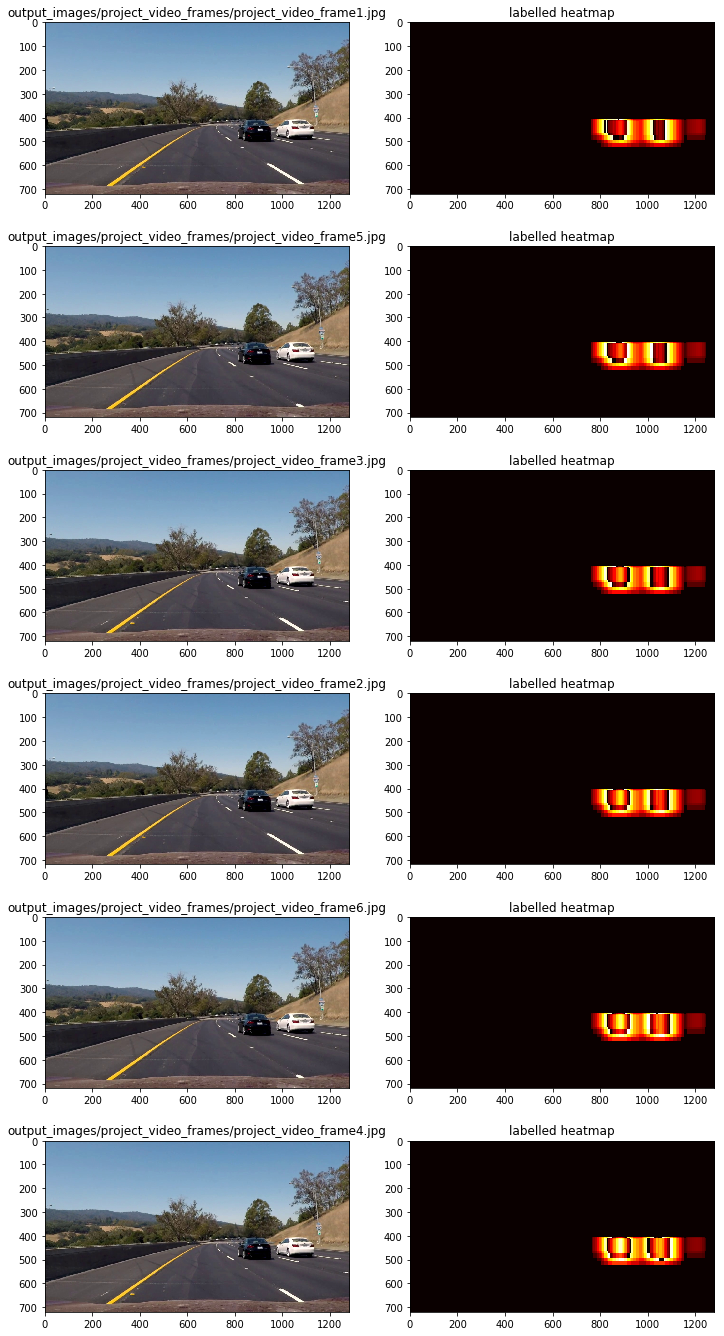

In [46]:
fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, lbl_images, lbl_titles)

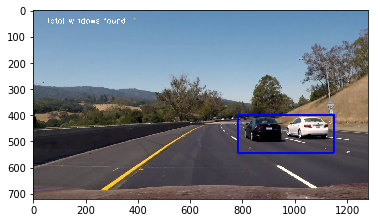

In [50]:
plt.imshow(draw_img)